In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.datasets import mnist
import keras_tuner as kt

from sklearn.model_selection import train_test_split, StratifiedKFold
import time

from numpy.random import seed
seed(1)

from tensorflow.compat.v1 import set_random_seed
set_random_seed(1)

## The Goal of This Notebook

The goal of this notebook is to show the contribution of Dropout Layer.

## Inspiration

I tried to replicate the mnist part of the experiment found in [[1]](https://jmlr.org/papers/v15/srivastava14a.html).

## Brief Introduction of Dropout Layer

Dropout layer is used for regularizing the neural networks. It is done by activating neurons of each layer according to a probability that have been determined before. Randomly activating neurons prevent complex cooperations to form inside of the network and force each neuron to work appropriately by themself. This is really helpful while dealing with overfitting.

### Mechanism

**Training**

While training, intended layer(s) is thinned (random partial activation). Thinned network makes a prediction and SGD updates the weights of the neurons that have been active in that given iteration. 

Since each time the used portion of the neural network is different, the gradient becomes considerable noisier compared to the regular neural networks. Therefore, typically same model with a dropout takes 2-3 times longer to converge.

**Prediction**

During prediction, each neurons are activated simultaneously and their contribution is averaged by multiplying the neuron weights with the predetermined activation probability. Prediction from averages is not the ideal way but since it works greatly and saves lots of computational resources, the layer algorithm have been coded in that fashion.

**Model Performance**

Dropout layer generally increases the model performance except these situations:

1. Very Small Dataset: If dataset is too small, the dropout layer itself just not enough to prevent overfitting.

2. Very Big Dataset: If there are lots of instances to work on and model performance is low, overfitting probably is not the reason behind so dropout won't help.

3. Very Low Random Selection Probability: The model becomes so thin that it cannot catch all the patterns (underfitting).

4. Very High Random Selection Probability: The model becomes similar to the one with no dropout. It probably still suffers from overfitting.

**Combination**

The Dropout layer works great by itself to prevent overfitting. On the other hand, combining dropout with other regularization techniques may increase the model performance further. One regularization method which suits well with dropout is "max-norm regularization".

## Methodology

In this notebook, I tried to stick the methods and parameters that have been used by researchers as much as I could. 

* I used a validation set having 1000 instances for tuning hyperparameters for each model. I used hyperband optimizer in this regard because is works greatly on neural networks.
* I used 0.8 random selection probability for inputs and 0.5 for hidden layers.
* I used SGD momentum as 0.95
* The last model I used explained in another paper. You can check [[2]](https://arxiv.org/abs/1302.4389).

## Updates

**25.07.2022** 

* I recorded to the the training times of the models so the effect of the dropout layer becomes more observable.  
* I separated Results & Discussion from the other parts and put it to the end of the notebook. I also added a conclusion part.
* I also conducted the experiment using KFold so that we can be sure about the contribution of the dropout layer. Please keep in mind that while using KFold train and test sizes differed from the experimental procedure.
* I could only plot first 6 epochs because every model required different number of epochs to converge.

Thanks The Devastator for the suggestions.

## Contents
1. [Preparation for the Experiment](#1)
1. [Standard Neural Nets (No Dropout)](#2)
1. [Three Hidden Layers - 1024 Units - Sigmoid](#3)
1. [Three Hidden Layers - 1024 Units - ReLU](#4)
1. [Three Hidden Layers - 1024 Units - ReLU - Max-Norm Constraint](#5)
1. [Three Hidden Layers - 2048 Units - ReLU - Max-Norm Constraint](#6)
1. [Two Hidden Layers - 4096 Units - ReLU - Max-Norm Constraint](#7)
1. [Two Hidden Layers - 8192 Units - ReLU - Max-Norm Constraint](#8)
1. [The Maxout Model ](#9)
1. [Model Comparison](#10)

In [2]:
# specs from paper
MOMENTUM = 0.95

(X_trn,y_trn),(X_tst,y_tst) = mnist.load_data()
X_train_deficient,X_validation,y_train_deficient,y_validation = train_test_split(X_trn,y_trn,test_size = 10000) #for tuning purposes

11501568/11490434 [==============================] - 0s 0us/step


<a id='1'></a>
## 1. Preparation for the Experiment 

In [3]:
class train_best_model():
    def __init__(self, num_hidden, units, activation,max_norm, dropout_layer,epochs, KFOLD):
        self.num_hidden = num_hidden
        self.units = units
        self.activation = activation
        self.max_norm = max_norm
        self.dropout_layer = dropout_layer
        self.epochs = epochs
        self.KFOLD = KFOLD
           

    def split_data(self):
        (X_train,y_train),(X_test,y_test) = mnist.load_data()
        X = np.concatenate([X_train,X_test], axis = 0)
        y = np.concatenate([y_train,y_test], axis = 0)
        val_index = np.random.randint(0,70000,10000)
        X_val,y_val = X[val_index],y[val_index] # randomly select 10000 samples for tuning
        train_data = []
        test_data = []
        skf = StratifiedKFold(n_splits = 3)
        for train_idx,test_idx in skf.split(X,y): #during training, validation samples should also be included
            X_train,y_train = X[train_idx],y[train_idx]
            X_test,y_test = X[test_idx],y[test_idx]
            train_data.append((X_train,y_train))
            test_data.append((X_test,y_test))
        return (train_data,test_data),(X_val,y_val)
    
    def create_model(self):
    
        inputs = layers.Input(shape = (28,28), name = "input")
        x = layers.Rescaling(1./255)(inputs)
        x = layers.Dropout(0.2)(x)
        x = layers.Flatten()(x)
        for _ in range(self.num_hidden):


            if (self.max_norm) & (self.dropout_layer):
                x = layers.Dense(self.units)(x)
                x = MaxNorm(max_value = 2)(x)
                x = layers.Dropout(0.5)(x)
                x = layers.Activation(self.activation)(x)

            elif (self.max_norm == False) & (self.dropout_layer == True):
                x = layers.Dense(self.units)(x)
                x = layers.Dropout(0.5)(x)
                x = layers.Activation(self.activation)(x)

            elif (self.max_norm == False) & (self.dropout_layer == False):
                x = layers.Dense(self.units, activation = self.activation)(x)

            else:
                pass
                
        outputs = layers.Dense(10)(x)

        model = tf.keras.Model(inputs,outputs)
        return model
    
    def find_params(self):
        
        def model_builder(hp):
            tune_model = self.create_model()
            hp_learning_rate = hp.Choice('learning_rate', values = [1e-2,1e-3,0.1])
            tune_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = hp_learning_rate,
                                               momentum = MOMENTUM),
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
            metrics = ['accuracy'])
            return tune_model
        
        tuner =  kt.Hyperband(model_builder,
                              objective='val_accuracy',
                              max_epochs=10,
                              factor=3,overwrite=True)
        early_stopping = tf.keras.callbacks.EarlyStopping(patience = 5)
        if self.KFOLD:
            
            _,val_data = self.split_data()
            (X_val,y_val) = val_data
            tuner.search(X_validation,y_validation, validation_split = 0.2, epochs = 50, callbacks = [early_stopping])
            best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
            LEARNING_RATE = best_hps.get('learning_rate')
        else:
            
            
            tuner.search(X_validation,y_validation, validation_split = 0.2, epochs = 50, callbacks = [early_stopping])
            best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
            LEARNING_RATE = best_hps.get('learning_rate')
        return LEARNING_RATE
    
    def train_final_model(self):
        final_model = self.create_model()
        final_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = self.find_params(),
                                               momentum = MOMENTUM),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ['accuracy'])
        if self.KFOLD:
            (train_data,test_data),_ = self.split_data()
            test_evals = []
            early_stopping = tf.keras.callbacks.EarlyStopping(patience = 5,
                                                             min_delta = 0.01)
            for (X_train,y_train),(X_test,y_test) in zip(train_data,test_data):
                final_model.fit(X_train,y_train, validation_data = (X_test,y_test), epochs = self.epochs,callbacks = [early_stopping])
                
                test_eval = final_model.evaluate(X_test,y_test)
                test_evals.append(test_eval[1])
            return test_evals
        
        else:
            early_stopping = tf.keras.callbacks.EarlyStopping(patience = 5,
                                                             min_delta = 0.01)
            start_time = time.time()
            history = final_model.fit(X_trn,y_trn, validation_data = (X_tst,y_tst), epochs = self.epochs,callbacks = [early_stopping])
            finish_time = time.time()
            time_it_takes = finish_time - start_time
            test_eval = final_model.evaluate(X_tst,y_tst)
            return history,test_eval,time_it_takes
        
def train_both_ways(model_specs):
    model_specs['KFOLD'] = True
    test_evals = train_best_model(**model_specs).train_final_model()
    model_specs['KFOLD'] = False
    history,test_eval,time_it_takes = train_best_model(**model_specs).train_final_model()
    
    return test_evals, (history,test_eval,time_it_takes)

In [4]:
class train_best_maxout_model():
    def __init__(self,epochs,KFOLD):
        self.KFOLD = KFOLD
        self.epochs = epochs
        
    def split_data(self):
        (X_train,y_train),(X_test,y_test) = mnist.load_data()
        X = np.concatenate([X_train,X_test], axis = 0)
        y = np.concatenate([y_train,y_test], axis = 0)
        val_index = np.random.randint(0,70000,10000)
        X_val,y_val = X[val_index],y[val_index] # randomly select 10000 samples for tuning
        train_data = []
        test_data = []
        skf = StratifiedKFold(n_splits = 3)
        for train_idx,test_idx in skf.split(X,y): #during training, validation samples should also be included
            X_train,y_train = X[train_idx],y[train_idx]
            X_test,y_test = X[test_idx],y[test_idx]
            train_data.append((X_train,y_train))
            test_data.append((X_test,y_test))
        return (train_data,test_data),(X_val,y_val)
    
    def create_model(self,units):
        inputs = tf.keras.Input(shape = (28,28))
        x = layers.Dropout(0.2)(inputs)
        x = layers.Flatten()(x)
        x = layers.Dense(units = units)(x)
        x = MaxNorm(max_value = 2)(x)
        x = layers.Dropout(0.5)(x)
        x = tfa.layers.Maxout(units)(x)
        x = layers.Dense(units = 20)(x)
        x = layers.Dropout(0.5)(x)
        x = tfa.layers.Maxout(10)(x)
        outputs = layers.Activation('softmax')(x)

        maxout_model = tf.keras.Model(inputs,outputs)
        return maxout_model
    
    def find_params(self):
        def model_builder(hp):
            hp_units = hp.Int('units',min_value = 32,max_value = 512, step = 32)
            hp_learning_rate = hp.Choice('learning_rate', values = [1e-2,1e-3,0.1])
            maxout_model = self.create_model(hp_units)
            maxout_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = hp_learning_rate,
                                               momentum = MOMENTUM),
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
            metrics = ['accuracy'])
            
            return maxout_model
        
        tuner = kt.Hyperband(model_builder,
                        objective='val_accuracy',
                          max_epochs=10,
                          factor=3,overwrite=True)
        early_stopping = tf.keras.callbacks.EarlyStopping(patience = 5)
        if self.KFOLD:
            
            _,val_data = self.split_data()
            (X_val,y_val) = val_data
            tuner.search(X_val,y_val, validation_split = 0.2, epochs = 50, callbacks = [early_stopping])
            best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
            LEARNING_RATE = best_hps.get('learning_rate')
            UNITS = best_hps.get('units')
        else:
            
            tuner.search(X_validation,y_validation, validation_split = 0.2, epochs = 50, callbacks = [early_stopping])
            best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
            LEARNING_RATE = best_hps.get('learning_rate')
            UNITS = best_hps.get('units')
        return LEARNING_RATE, UNITS
    
    def train_final_model(self):
        LEARNING_RATE,UNITS = self.find_params()
        final_model = self.create_model(UNITS)
        final_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE,
                                               momentum = MOMENTUM),
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
            metrics = ['accuracy'])
        
        if self.KFOLD:
            (train_data,test_data),_ = self.split_data()
            test_evals = []
            early_stopping = tf.keras.callbacks.EarlyStopping(patience = 5,
                                                             min_delta = 0.01)
            for (X_train,y_train),(X_test,y_test) in zip(train_data,test_data):
                final_model.fit(X_train,y_train, validation_data = (X_test,y_test), epochs = self.epochs,
                                callbacks = [early_stopping])
                
                test_eval = final_model.evaluate(X_test,y_test)
                test_evals.append(test_eval[1])
            return test_evals
        
        else:
            early_stopping = tf.keras.callbacks.EarlyStopping(patience = 5,
                                                             min_delta = 0.01)
            start_time = time.time()
            history = final_model.fit(X_trn,y_trn, validation_data = (X_tst,y_tst),epochs = self.epochs,callbacks = [early_stopping])
            finish_time = time.time()
            time_it_takes = finish_time - start_time
            test_eval = final_model.evaluate(X_tst,y_tst)

            return history,test_eval, time_it_takes
        
def train_maxout_both_ways(model_specs):
    model_specs['KFOLD'] = True
    test_evals = train_best_maxout_model(**model_specs).train_final_model()
    model_specs['KFOLD'] = False
    history,test_eval,time_it_takes = train_best_maxout_model(**model_specs).train_final_model()
    
    return test_evals, (history,test_eval,time_it_takes)

<a id='2'></a>
## 2. Standard Neural Nets (No Dropout)

In [5]:
model_specs = {'num_hidden': 2,
              'units': 800,
              'activation': 'sigmoid',
              'max_norm': False,
              'dropout_layer': False,
               'epochs': 100}
fold_evals_1,evals_1 = train_both_ways(model_specs)

Trial 3 Complete [00h 00m 01s]
val_accuracy: 0.49050000309944153

Best val_accuracy So Far: 0.8349999785423279
Total elapsed time: 00h 00m 05s
Epoch 1/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6823 - accuracy: 0.7819 - val_loss: 0.3286 - val_accuracy: 0.9063
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3589 - accuracy: 0.8910 - val_loss: 0.2855 - val_accuracy: 0.9196
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3042 - accuracy: 0.9082 - val_loss: 0.2519 - val_accuracy: 0.9245
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2624 - accuracy: 0.9205 - val_loss: 0.2048 - val_accuracy: 0.9390
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2256 - accuracy: 0.9308 - val_loss: 0.1883 - val_accuracy: 0.9421
Epoch 6/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2038 - accuracy: 0.9377 - val_loss: 0.1656 - val_accu

<a id='3'></a>
## 3. Three Hidden Layers - 1024 Units - Sigmoid

In [6]:
model_specs = {'num_hidden': 3,
              'units': 1024,
              'activation': 'sigmoid',
              'max_norm': False,
              'dropout_layer': True,
              'epochs': 100}
fold_evals_2,evals_2 = train_both_ways(model_specs)

Trial 3 Complete [00h 00m 03s]
val_accuracy: 0.10050000250339508

Best val_accuracy So Far: 0.10400000214576721
Total elapsed time: 00h 00m 08s
Epoch 1/100
1875/1875 [==============================] - 5s 2ms/step - loss: 6.4128 - accuracy: 0.1010 - val_loss: 2.3445 - val_accuracy: 0.0980
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 6.3325 - accuracy: 0.1002 - val_loss: 2.3851 - val_accuracy: 0.0980
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 6.5141 - accuracy: 0.1039 - val_loss: 2.3530 - val_accuracy: 0.0980
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 6.6304 - accuracy: 0.1005 - val_loss: 2.3409 - val_accuracy: 0.0980
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 6.4283 - accuracy: 0.0985 - val_loss: 2.3611 - val_accuracy: 0.0980
Epoch 6/100
313/313 [==============================] - 1s 3ms/step - loss: 2.3394 - accuracy: 0.1032


<a id='4'></a>
## 4. Three Hidden Layers - 1024 Units - ReLU

In [7]:
model_specs = {'num_hidden': 3,
              'units': 1024,
              'activation': 'relu',
              'max_norm': False,
              'dropout_layer': True,
              'epochs': 100}
fold_evals_3,evals_3 = train_both_ways(model_specs)

Trial 3 Complete [00h 00m 03s]
val_accuracy: 0.9240000247955322

Best val_accuracy So Far: 0.9240000247955322
Total elapsed time: 00h 00m 09s
Epoch 1/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4470 - accuracy: 0.8592 - val_loss: 0.1497 - val_accuracy: 0.9543
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2472 - accuracy: 0.9253 - val_loss: 0.1244 - val_accuracy: 0.9617
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2062 - accuracy: 0.9393 - val_loss: 0.1021 - val_accuracy: 0.9695
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1859 - accuracy: 0.9456 - val_loss: 0.1022 - val_accuracy: 0.9676
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1667 - accuracy: 0.9515 - val_loss: 0.0877 - val_accuracy: 0.9728
Epoch 6/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1541 - accuracy: 0.9549 - val_loss: 0.0906 - val_accur

<a id='5'></a>
## 5. Three Hidden Layers - 1024 Units - ReLU - Max-Norm Constraint

In [8]:
model_specs = {'num_hidden': 3,
              'units': 1024,
              'activation': 'relu',
              'max_norm': True,
              'dropout_layer': True,
              'epochs': 100}
fold_evals_4,evals_4 = train_both_ways(model_specs)

Trial 3 Complete [00h 00m 03s]
val_accuracy: 0.8414999842643738

Best val_accuracy So Far: 0.9185000061988831
Total elapsed time: 00h 00m 09s
Epoch 1/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4604 - accuracy: 0.8554 - val_loss: 0.1594 - val_accuracy: 0.9504
Epoch 2/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2396 - accuracy: 0.9264 - val_loss: 0.1216 - val_accuracy: 0.9638
Epoch 3/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1894 - accuracy: 0.9421 - val_loss: 0.0955 - val_accuracy: 0.9694
Epoch 4/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1660 - accuracy: 0.9489 - val_loss: 0.0870 - val_accuracy: 0.9727
Epoch 5/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1452 - accuracy: 0.9552 - val_loss: 0.0811 - val_accuracy: 0.9746
Epoch 6/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1346 - accuracy: 0.9586 - val_loss: 0.0790 - val_accur

<a id='6'></a>
## 6. Three Hidden Layers - 2048 Units - ReLU - Max-Norm Constraint

In [9]:
model_specs = {'num_hidden': 3,
              'units': 2048,
              'activation': 'relu',
              'max_norm': True,
              'dropout_layer': True,
              'epochs': 100}
fold_evals_5,evals_5 = train_both_ways(model_specs)

Trial 3 Complete [00h 00m 02s]
val_accuracy: 0.8740000128746033

Best val_accuracy So Far: 0.9179999828338623
Total elapsed time: 00h 00m 09s
Epoch 1/100
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4306 - accuracy: 0.8630 - val_loss: 0.1491 - val_accuracy: 0.9521
Epoch 2/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2238 - accuracy: 0.9305 - val_loss: 0.1087 - val_accuracy: 0.9676
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1761 - accuracy: 0.9456 - val_loss: 0.0935 - val_accuracy: 0.9695
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1497 - accuracy: 0.9535 - val_loss: 0.0895 - val_accuracy: 0.9736
Epoch 5/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1328 - accuracy: 0.9592 - val_loss: 0.0847 - val_accuracy: 0.9739
Epoch 6/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1233 - accuracy: 0.9615 - val_loss: 0.0782 - val_accur

<a id='7'></a>
## 7. Two Hidden Layers - 4096 Units - ReLU - Max-Norm Constraint

In [10]:
model_specs = {'num_hidden': 2,
              'units': 4096,
              'activation': 'relu',
              'max_norm': True,
              'dropout_layer': True,
              'epochs': 100}
fold_evals_6,evals_6 = train_both_ways(model_specs)

Trial 3 Complete [00h 00m 06s]
val_accuracy: 0.9179999828338623

Best val_accuracy So Far: 0.9179999828338623
Total elapsed time: 00h 00m 18s
Epoch 1/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3863 - accuracy: 0.8813 - val_loss: 0.1532 - val_accuracy: 0.9528
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2243 - accuracy: 0.9311 - val_loss: 0.1220 - val_accuracy: 0.9625
Epoch 3/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1734 - accuracy: 0.9472 - val_loss: 0.0980 - val_accuracy: 0.9685
Epoch 4/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1488 - accuracy: 0.9546 - val_loss: 0.0999 - val_accuracy: 0.9698
Epoch 5/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1283 - accuracy: 0.9603 - val_loss: 0.0857 - val_accuracy: 0.9732
Epoch 6/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1180 - accuracy: 0.9624 - val_loss: 0.0855 - val_accur

<a id='8'></a>
## 8. Two Hidden Layers - 8192 Units - ReLU - Max-Norm Constraint

In [11]:
model_specs = {'num_hidden': 2,
              'units': 8192,
              'activation': 'relu',
              'max_norm': True,
              'dropout_layer': True,
              'epochs': 100}
fold_evals_7,evals_7 = train_both_ways(model_specs)

Trial 3 Complete [00h 00m 11s]
val_accuracy: 0.8974999785423279

Best val_accuracy So Far: 0.9110000133514404
Total elapsed time: 00h 00m 26s
Epoch 1/100
1875/1875 [==============================] - 17s 8ms/step - loss: 0.4559 - accuracy: 0.8682 - val_loss: 0.2459 - val_accuracy: 0.9333
Epoch 2/100
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2877 - accuracy: 0.9214 - val_loss: 0.1457 - val_accuracy: 0.9616
Epoch 3/100
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2308 - accuracy: 0.9369 - val_loss: 0.1295 - val_accuracy: 0.9660
Epoch 4/100
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1958 - accuracy: 0.9461 - val_loss: 0.1229 - val_accuracy: 0.9684
Epoch 5/100
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1705 - accuracy: 0.9533 - val_loss: 0.1050 - val_accuracy: 0.9712
Epoch 6/100
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1589 - accuracy: 0.9556 - val_loss: 0.1230 - val

<a id='9'></a>
## 9. The Maxout Model 

In [18]:
model_specs = {
    'epochs':100
}
fold_evals_8,evals_8 = train_maxout_both_ways(model_specs)

Trial 30 Complete [00h 00m 07s]
val_accuracy: 0.9079999923706055

Best val_accuracy So Far: 0.9079999923706055
Total elapsed time: 00h 02m 04s
Epoch 1/100
1875/1875 [==============================] - 5s 2ms/step - loss: 1.1516 - accuracy: 0.6190 - val_loss: 0.4606 - val_accuracy: 0.9060
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9762 - accuracy: 0.6747 - val_loss: 0.3942 - val_accuracy: 0.9131
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9436 - accuracy: 0.6861 - val_loss: 0.3716 - val_accuracy: 0.9175
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9306 - accuracy: 0.6906 - val_loss: 0.3533 - val_accuracy: 0.9209
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9194 - accuracy: 0.6920 - val_loss: 0.3462 - val_accuracy: 0.9202
Epoch 6/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9150 - accuracy: 0.6949 - val_loss: 0.3395 - val_accu

<a id='10'></a>
## 10. Model Comparison

In [20]:
# DNN: Dropout Neural Networks
evaluations = [evals_1[1],
              evals_2[1],
              evals_3[1],
              evals_4[1],
              evals_5[1],
              evals_6[1],
              evals_7[1],
              evals_8[1]]

accuracy = [val_acc[1] for val_acc in evaluations]
errors = np.subtract(1,accuracy)*100

convergence_times = [
          evals_1[2],
          evals_2[2],
          evals_3[2],
          evals_4[2],
          evals_5[2],
          evals_6[2],
          evals_7[2],
          evals_8[2]
]

fold_mean_accuracies = [
    np.mean(fold_evals_1),
    np.mean(fold_evals_2),
    np.mean(fold_evals_3),
    np.mean(fold_evals_4),
    np.mean(fold_evals_5),
    np.mean(fold_evals_6),
    np.mean(fold_evals_7),
    np.mean(fold_evals_8),
]

fold_mean_errors = np.subtract(1,fold_mean_accuracies)*100

methods = [
    "Standard Neural Net",
    "DNN Logistic 3 layers, 1024 units",
    "DNN ReLU 3 layers, 1024 units",
    "DNN + max-norm constraint ReLU 3 layers, 1024 units",
    "DNN + max-norm constraint ReLU 3 layers, 2048 units",
    "DNN + max-norm constraint ReLU 2 layers, 4096 units",
    "DNN + max-norm constraint ReLU 2 layers, 8192 units",
   " DNN + max-norm constraint Maxout"
    
]

paper_results = [
    1.60,
    1.35,
    1.25,
    1.06,
    1.04,
    1.01,
    0.95,
    0.94
]

comparison_df = pd.DataFrame()
comparison_df["Method"] = methods
comparison_df["Paper Results"] = paper_results
comparison_df["Replication Results"] = errors
comparison_df["Mean Fold Results"] = fold_mean_errors
comparison_df["Convergence Times"] = convergence_times

comparison_df

,Method,Paper Results,Replication Results,Mean Fold Results,Convergence Times
0,Standard Neural Net,1.60,1.899999,1.812845,96.888669
1,"DNN Logistic 3 layers, 1024 units",1.35,89.680000,8.131405,25.225610
2,"DNN ReLU 3 layers, 1024 units",1.25,1.969999,1.641419,53.379341
3,"DNN + max-norm constraint ReLU 3 layers, 1024 ...",1.06,1.660001,1.584278,100.478144
4,"DNN + max-norm constraint ReLU 3 layers, 2048 ...",1.04,1.810002,1.541420,83.925958
5,"DNN + max-norm constraint ReLU 2 layers, 4096 ...",1.01,1.760000,1.278563,83.561107
6,"DNN + max-norm constraint ReLU 2 layers, 8192 ...",0.95,2.029997,1.341418,255.168419
7,DNN + max-norm constraint Maxout,0.94,7.389998,8.761420,63.959272


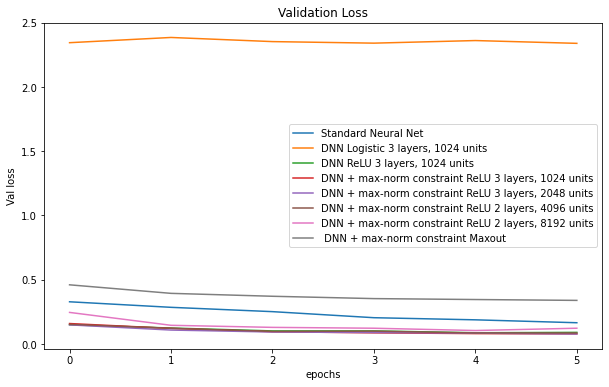

In [24]:
histories = [
     evals_1[0],
     evals_2[0],
     evals_3[0],
     evals_4[0],
     evals_5[0],
     evals_6[0],
     evals_7[0],
     evals_8[0],
     
]

val_acc_history = [hist.history["val_accuracy"] for hist in histories]
val_loss_history = [hist.history["val_loss"] for hist in histories]
epochs = list(range(6))

plt.figure(figsize = (10,6))
for idx,val_loss in enumerate(val_loss_history):
    plt.plot(epochs,val_loss[:6], label = comparison_df["Method"][idx])
plt.legend()
plt.ylabel('Val loss')
plt.xlabel("epochs")
plt.title("Validation Loss")
plt.show()


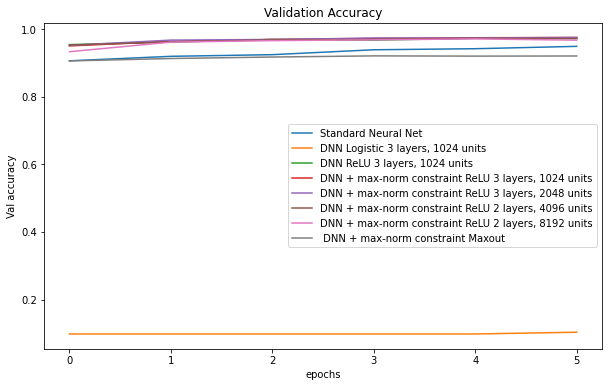

In [25]:
plt.figure(figsize = (10,6))
for idx,val_acc in enumerate(val_acc_history):
    plt.plot(epochs,val_acc[:6], label = comparison_df["Method"][idx])
plt.legend()
plt.ylabel('Val accuracy')
plt.xlabel("epochs")
plt.title("Validation Accuracy")
plt.show()


## Results & Discussion

Most of the results I obtained are similar; on the other hand, the model performances of **`DNN + max-norm constraint Maxout`** and **`DNN Logistic 3 layers, 1024 units`** are undeniably worse. One thing that I want to point out is the significant performance boost of **`DNN Logistic 3 layers, 1024 units`**. In the previous version, I only measured the model performance with one train-test split and linked the low-performance output to the Vanishing Gradient Problem. If that was the case, the model performance should also be lower in folded data but clearly, it is not. The folded performance output is still lower than expected but much better compared to the single train-test split data. (Even there is fewer data to train 46666 to 60000 respectively).

Regarding convergence times, the results I got are not parallel to the theory but they are also not consistent with each other. For example, **`DNN + max-norm constraint ReLU 3 layers, 1024 units`** is a smaller model compared to the **`DNN + max-norm constraint ReLU 3 layers, 2048 units`** yet it took a longer time to converge. This is just one example. When you look at the comparison data frame, you can catch more of these inconsistencies.

## Conclusion

From the theoretical point of view, when overfitting is the case, one can utilize dropout layer(s) to increase the generalization power of the neural networks. It prevents complex cooperations to form during the training process and it makes overfitting less likely. One important thing to consider is the convergence time. While dropout layer(s) can serve a lot, it can slow down the training process considerably. 

I have to admit some of the results I got don't confirm the theory. Therefore I'm open to suggestions. If you have, please don't hesitate to share.

Thanks...